In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import pandas as pd

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

sns.set(style="ticks", context='poster')
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
%matplotlib inline

# Figure 6

In [2]:
# Load DFE data
DFE_data = pd.read_csv('./raw_data/DFE.csv')

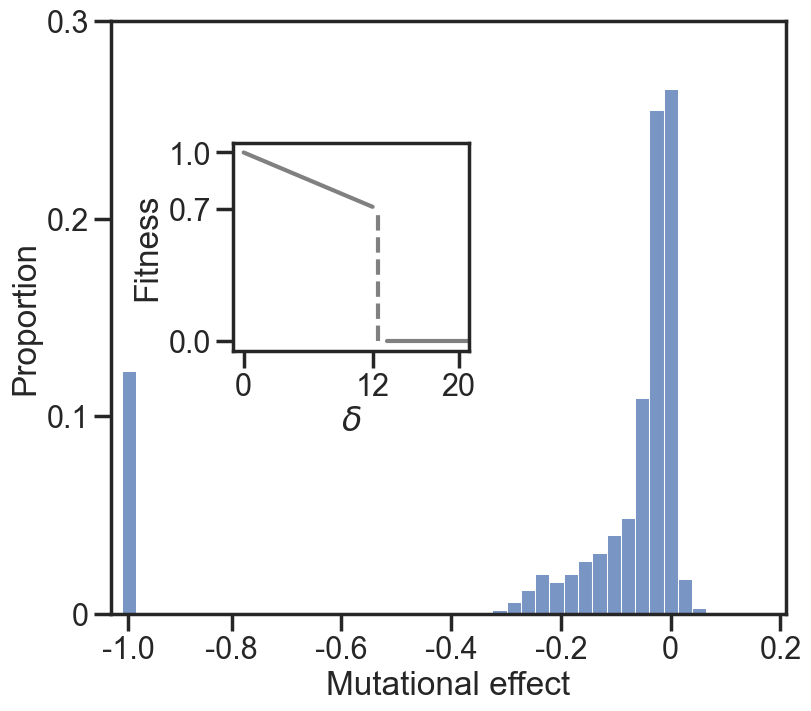

In [3]:
def fitness_funct(d, w_min=0.7, δ=11.7):
    slope = np.divide(w_min - 1, δ)
    w = slope*d + 1
    if w < w_min:
        w = 0
    return w

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 7),
    constrained_layout=True)

sns.histplot(data=DFE_data, x='prop', stat='proportion', bins=55)

ax.set_xlabel(r'Mutational effect')
ax.set_ylim(0, 0.3)
ax.set_yticks(np.linspace(0, 0.3, 4))
ax.set_yticklabels([0, 0.1, 0.2, 0.3])
ax.set_xlim(-1.02, 0.21)
ax.set_xticks([-0.988, -0.8, -0.6, -0.4,-0.2, 0,  0.2])
ax.set_xticklabels([-1.0, -0.8, -0.6, -0.4,-0.2, 0,  0.2])
s_total = np.mean(DFE_data.prop)
s_wo_lethal = np.mean(DFE_data.prop[DFE_data.prop != 0])
s_benef = np.sum(DFE_data.prop > 1)/len(DFE_data.prop)

axins = inset_axes(ax, width="35%", height="35%", loc=2, borderpad=4)

axins.set(xlabel=r'$\delta$', ylabel=r'Fitness', xticks=[0, 12, 20], yticks=[0, 0.7, 1], xlim=(-1,21))
x = np.arange(0, 13, 1)
axins.plot(x, [fitness_funct(i, 0.7, 12.5) for i in x], '-', label='0.7', lw=3, color='gray')

x = np.arange(13.3, 30, 1)
axins.plot(x, [fitness_funct(i, 0.7, 12) for i in x], '-', label='0.7', lw=3, color='gray')

axins.set_ylim(-0.05, 1.05)

axins.vlines(12.5, 0, 0.7, ls='dashed', lw=3, color='gray')

# Figure 7

In [4]:
# Load qRNA model results
qRNA_data = pd.read_csv('./raw_data/RNA_q_results.csv')

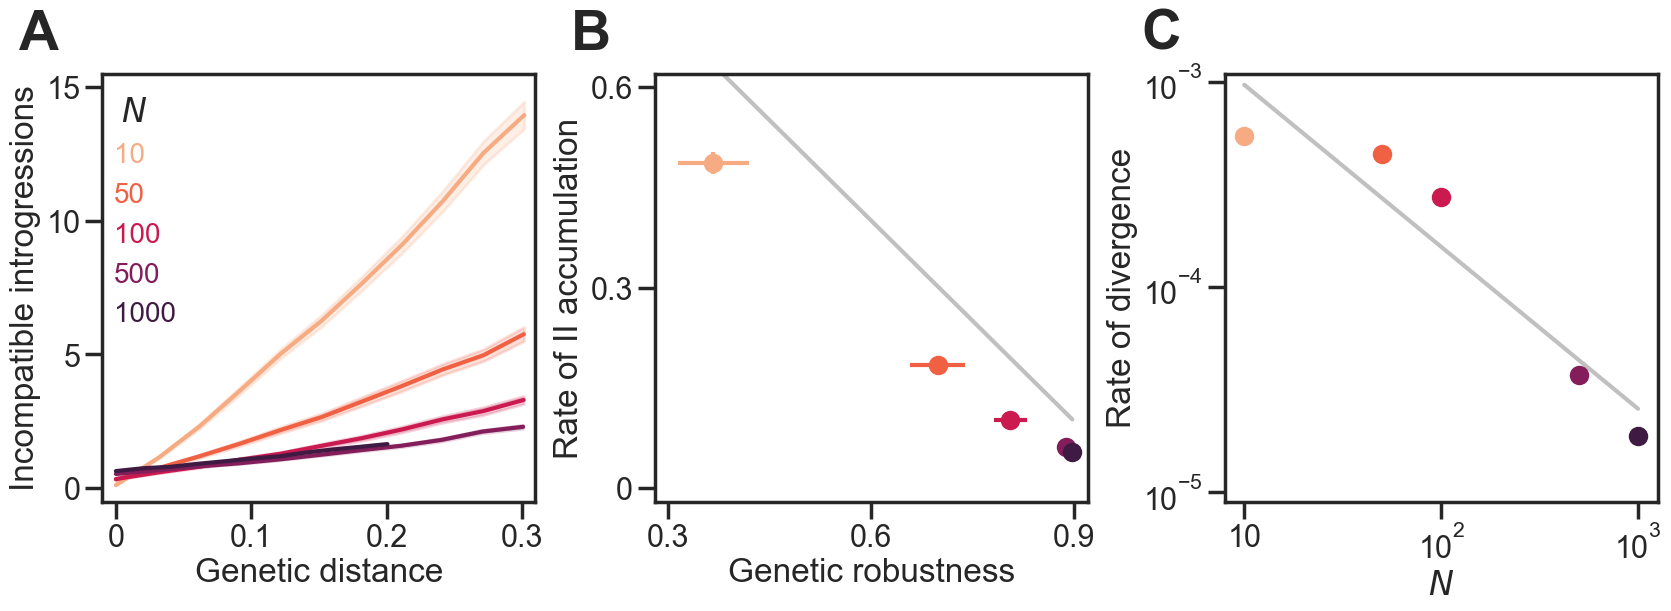

In [5]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(16.6, 6), constrained_layout=True)


axes = axes.flatten()

N_pops = [10, 50, 100, 500, 1000]

fits = pd.DataFrame()
count = 0
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['D'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['II'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'N': [N], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits = pd.concat([fits, temp])
        count += 1

count = 0
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    err = 1.96* new_data.groupby('stp')['II'].std()/np.sqrt(len(new_data)/len(x_data))
    if N == 1000:
        clip_threshold = 0.21
    else:
        clip_threshold = 0.31
    # Mask the values that exceed the threshold
    err_masked = np.ma.masked_where(x_data > clip_threshold, err)
    x_masked = np.ma.masked_where(x_data > clip_threshold, x_data)
    y_masked = np.ma.masked_where(x_data > clip_threshold, y_data)
    axes[0].errorbar(x_masked, y_masked, fmt='-', linewidth=3, capsize=0, markersize=12, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], label=N)
    axes[0].fill_between(x_masked, y_masked - err_masked, y_masked + err_masked, alpha=0.2, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count])
    count += 1
    
exp_II = []
robs = []
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    exp_II.append(1 - np.mean(new_data.groupby('stp')['nu'].mean()))
    robs.append(np.mean(new_data.groupby('stp')['nu'].mean()))
axes[1].plot(robs, exp_II, color='silver', zorder=0)
    
axes[0].set_ylim(-0.5, 15.5)
axes[0].set_xlim(-0.01, 0.31)
axes[0].set_xticks(np.linspace(0, 0.3, 4))
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3])
axes[0].set_ylabel('Incompatible introgressions')
axes[0].set_xlabel(r'Genetic distance')

lg = axes[0].legend(loc=(-0.05,0.38), frameon=False, markerscale=0, handlelength=0, handleheight=0.1, labelcolor='linecolor', prop={'weight':'normal', 'size':'small'}, title=r'$\it{N}$')

count = 0
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    new_data_fit = fits[fits['N']==N]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    y_data = y_data/100.
    err = err/100.
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[1].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count)
    axes[1].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count)
    axes[1].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count])
    count += 1
axes[1].set_ylabel(r'Rate of II accumulation')
axes[1].set_xlabel(r'Genetic robustness')


fits_div = pd.DataFrame()
count = 0
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['gen'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['D'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'N': [N], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits_div = pd.concat([fits_div, temp])
        count += 1
        
fits = []
for N in N_pops:
    new_data_fit = fits_div[fits_div['N']==N]
    fits.append(np.mean(new_data_fit['slope']))
model = LinearRegression()
model.fit(np.log(N_pops).reshape(-1, 1), np.log(fits))
axes[2].plot(N_pops, [np.exp(model.coef_[0]*i +  model.intercept_) for i in np.log(N_pops)], color='silver', zorder=0)

count = 0
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    new_data_fit = fits_div[fits_div['N']==N]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    axes[2].scatter(N, y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count+1)
    axes[2].vlines(N, y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(N_pops))[count], zorder=count+1)
    count += 1
    
axes[2].set_xscale('log')
axes[2].set_yscale('log')

axes[2].set_ylabel(r'Rate of divergence')
axes[2].set_xlabel(r'$N$')
axes[2].set_ylim(0.9e-5, 1.1e-3)
axes[2].minorticks_off()

axes[2].set_xticks([10, 100, 1000])
axes[2].set_xticklabels(['$\\mathdefault{10}$','$\\mathdefault{10^{2}}$','$\\mathdefault{10^{3}}$'])

for i, label in enumerate(('A', 'B', 'C')):
    axes[i].text(-0.1, 1.15, label, transform=axes[i].transAxes,fontsize=40, fontweight='bold', va='top', ha='right')

axes[0].set_yticks(np.linspace(0, 15, 4))

axes[1].set_ylim(-0.02, 0.62)
axes[1].set_xlim(0.28, 0.92)
axes[1].set_xticks(np.linspace(0.3, 0.9, 3))
axes[1].set_yticks(np.linspace(0., 0.6, 3))
axes[1].set_yticklabels([0, 0.3, 0.6])

lg.get_title().set_position((0, 0));
#plt.savefig('./Fig7.svg', bbox_inches='tight', dpi=100);

In [6]:
np.round(model.coef_[0], decimals=1)

-0.8

# Figure 8

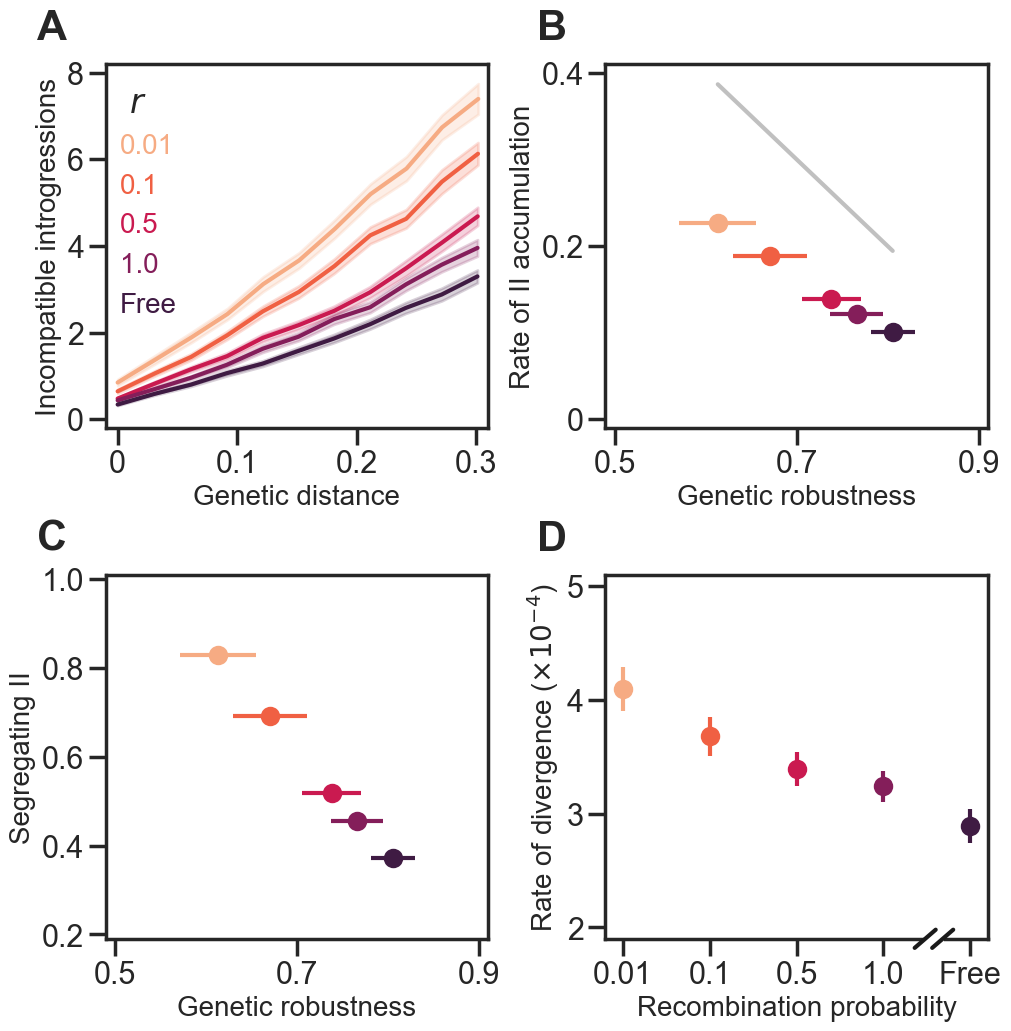

In [7]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 10.2), constrained_layout=True)

axes = axes.flatten()

r_pops = [0.01, 0.1, 0.5, 1.0, 'Free']

fits = pd.DataFrame()
count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['D'])[1:].reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['II'])[1:]
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'r': [r], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits = pd.concat([fits, temp])
        count += 1

count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    err = 1.96* new_data.groupby('stp')['II'].std()/np.sqrt(len(new_data)/len(x_data))
    clip_threshold = 0.31
    # Mask the values that exceed the threshold
    err_masked = np.ma.masked_where(x_data > clip_threshold, err)
    x_masked = np.ma.masked_where(x_data > clip_threshold, x_data)
    y_masked = np.ma.masked_where(x_data > clip_threshold, y_data)
    axes[0].errorbar(x_masked, y_masked, fmt='-', linewidth=3, capsize=0, markersize=12, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count], label=r)
    axes[0].fill_between(x_masked, y_masked - err_masked, y_masked + err_masked, alpha=0.2, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    count += 1

axes[0].set_ylim(-0.2, 8.2)
axes[0].set_xlim(-0.01, 0.31)
axes[0].set_ylabel('Incompatible introgressions', fontsize=20)
axes[0].set_xlabel(r'Genetic distance', fontsize=20)

handles, labels = axes[0].get_legend_handles_labels()

count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    new_data_fit = fits[fits['r']==r]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    y_data = y_data/100.
    err = err/100.
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[1].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[1].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[1].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    count += 1
axes[1].set_ylabel(r'Rate of II accumulation', fontsize=20)
axes[1].set_xlabel(r'Genetic robustness', fontsize=20)
axes[1].set_ylim(-0.01, 0.41)
axes[1].set_xlim(0.49, 0.91)
axes[1].set_xticks(np.linspace(0.5, 0.9, 3))


exp_II = []
robs = []
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    exp_II.append(1 - np.mean(new_data.groupby('stp')['nu'].mean()))
    robs.append(np.mean(new_data.groupby('stp')['nu'].mean()))
axes[1].plot(robs, exp_II, color='silver', zorder=0)

count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    y_data = np.mean(new_data.groupby('stp')['segII'].mean())
    err = 1.96*np.std(new_data['segII'])/np.sqrt(len(new_data['segII']))
    err_rob = 1.96*np.mean(new_data.groupby('stp')['nu'].std())/np.sqrt(len(new_data.groupby('stp')['nu'].mean()))
    axes[2].scatter(np.mean(new_data.groupby('stp')['nu'].mean()), y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[2].vlines(np.mean(new_data.groupby('stp')['nu'].mean()), y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    axes[2].hlines(y_data, np.mean(new_data.groupby('stp')['nu'].mean()) - err_rob, np.mean(new_data.groupby('stp')['nu'].mean()) + err_rob, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count])
    count += 1
axes[2].set_ylabel(r'Segregating II', fontsize=20)
axes[2].set_xlabel(r'Genetic robustness', fontsize=20)
axes[2].set_xlim(0.49, 0.91)
axes[2].set_ylim(0.19, 1.01)
axes[2].set_xticks(np.linspace(0.5, 0.9, 3))
count = 0

fits_div = pd.DataFrame()
count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    reps = np.unique(new_data['Sim'])
    for j in reps: 
        x = np.array(new_data[new_data['Sim']==j]['gen']).reshape(-1, 1)
        y = np.array(new_data[new_data['Sim']==j]['D'])
        model = LinearRegression()
        model.fit(x,y)
        temp = pd.DataFrame.from_dict({'ID': [count], 'r': [r], 'slope': [model.coef_[0]], 'intercept': [model.intercept_]})
        fits_div = pd.concat([fits_div, temp])
        count += 1

count = 0
for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    new_data_fit = fits_div[fits_div['r']==r]
    y_data = np.mean(new_data_fit['slope'])
    err = 1.96*np.std(new_data_fit['slope'])/np.sqrt(len(new_data_fit))
    axes[3].scatter(count, y_data, clip_on=True, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count], zorder=count)
    axes[3].vlines(count, y_data - err, y_data + err, color=sns.color_palette('rocket_r', n_colors=len(r_pops))[count], zorder=count)
    count += 1
    
#axes[3].set_yscale('log')
axes[3].set_ylabel(r'$N_e$', fontsize=20)
axes[3].set_xlabel(r'Recombination probability', fontsize=20)
axes[3].set_xticks([0, 1, 2, 3, 4])
axes[3].set_xticklabels(r_pops)
axes[3].set_ylabel(r'Rate of divergence ($\times 10^{-4}$)', fontsize=20)


axes[3].add_patch(patches.Rectangle((3.48, 1.85e-4), 0.19, 1e-5, color="white", fill=True, clip_on=False, zorder=9))

d = 0.025  # line length 
axes[3].plot((0.84-d - 0.0058, 0.845+d - 0.0058), (-d, +d), c='k',linewidth=3, clip_on=False, transform=axes[3].transAxes, zorder=10)
axes[3].plot((0.84-d +0.04, 0.845+d+0.04), (-d, +d), c='k',linewidth=3, clip_on=False, transform=axes[3].transAxes, zorder=10)

for i, label in enumerate(('A', 'B', 'C', 'D')):
    axes[i].text(-0.1, 1.15, label, transform=axes[i].transAxes,fontsize=30, fontweight='bold', va='top', ha='right')

axes[3].set_ylim(0.00019, 0.00051)

lg = axes[0].legend(loc=(-0.05,0.27), frameon=False, markerscale=0, handlelength=0, handleheight=0.1, labelcolor='linecolor', prop={'weight':'normal', 'size':'small'},title=r'$\it{r}$')
lg.get_title().set_position((0, 0))

axes[0].set_xlim(-0.01, 0.31)
axes[0].set_xticks(np.linspace(0, 0.3, 4))

axes[1].set_yticks(np.linspace(0, 0.4, 3))
axes[1].set_yticklabels([0,  0.2, 0.4])

axes[3].set_yticks([0.0002, 0.0003, 0.0004, 0.0005])
axes[3].set_yticklabels([2, 3, 4, 5])


axes[0].set_xticklabels([0, 0.1, 0.2, 0.3]);
    
#plt.savefig('./Fig8.svg', bbox_inches='tight', dpi=100);

In [8]:
def func(x, a, b, c):
    #return a * x**b + c
    return a * (x*100 -  1)**b + c

In [9]:
N_pops = [10, 50, 100, 500, 1000]

fits = pd.DataFrame()
for N in N_pops:
    new_data = qRNA_data[(qRNA_data['N']==N)&(qRNA_data['r']=='Free')]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    x_data = np.array(x_data[1:])
    y_data = np.array(y_data[1:])
    # Use curve_fit to find the parameters that best fit the data
    params, covariance = curve_fit(func, x_data, y_data)

    # Extract the fitted parameters
    a_fit, b_fit, c_fit = params
    print(N, np.round(a_fit, decimals=2), np.round(b_fit, decimals=2))

10 0.24 1.19
50 0.08 1.23
100 0.02 1.44
500 0.01 1.39
1000 0.03 1.21


In [10]:
r_pops = [0.01, 0.1, 0.5, 1.0, 'Free']

for r in r_pops:
    new_data = qRNA_data[(qRNA_data['N']==100)&(qRNA_data['r']==str(r))]
    x_data = new_data.groupby('stp')['D'].mean()
    y_data = new_data.groupby('stp')['II'].mean()
    x_data = np.array(x_data[1:])
    y_data = np.array(y_data[1:])
    # Use curve_fit to find the parameters that best fit the data
    params, covariance = curve_fit(func, x_data, y_data)

    # Extract the fitted parameters
    a_fit, b_fit, c_fit = params
    print(r, np.round(a_fit, decimals=2), np.round(b_fit, decimals=2))

0.01 0.08 1.29
0.1 0.07 1.26
0.5 0.03 1.47
1.0 0.04 1.29
Free 0.02 1.44


# Figure 9

In [11]:
#Load backcross data
bcross_data = pd.read_csv('./raw_data/backcross.csv')

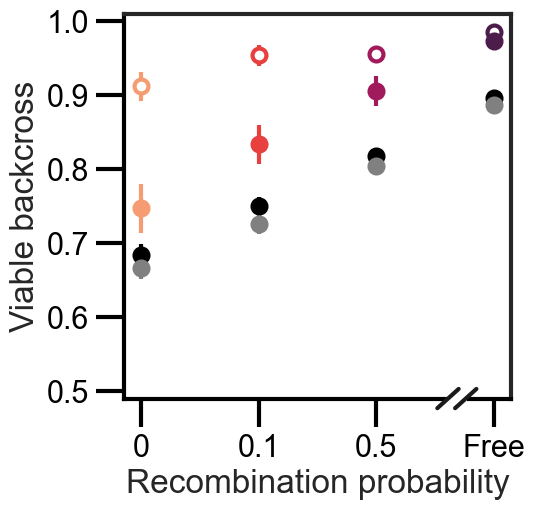

In [12]:
grad = sns.color_palette('rocket_r', n_colors=4)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 25})
ax.tick_params(axis='x', which='both', bottom=True, top=False,
    labelbottom=True, size=20, width=3, direction='out', pad=5, colors='black')
ax.tick_params(axis='y', which='both', left=True, right=False,
    labelbottom=False, size=20, width=3, direction='out', pad=5, colors='black')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

count = 0
for i,j in zip([0.0, 0.1, 0.5, 'Free'],  [0, 1, 2, 3]):
    temp = np.array(bcross_data[bcross_data['r']==str(i)]['anc_rob_II'])
    y = np.mean(temp)
    err = 1.96*np.std(temp)/np.sqrt(len(temp))
    ax.errorbar(j, y, yerr=err, fmt='-o',linewidth=3, capsize=0,mew=3, markersize=10, clip_on=False, color='black')
    count += 1
    
count = 0
for i,j in zip([0.0, 0.1, 0.5, 'Free'],  [0, 1, 2, 3]):
    temp = np.array(bcross_data[bcross_data['r']==str(i)]['backcross_non_II'])
    y = np.mean(temp)
    err = 1.96*np.std(temp)/np.sqrt(len(temp))
    ax.errorbar(j, y, yerr=err, fmt='-o',linewidth=3, capsize=0,mew=3, mfc='w', markersize=10, clip_on=False, color=grad[count])
    count += 1
    
count = 0
for i,j in zip([0.0, 0.1, 0.5, 'Free'],  [0, 1, 2, 3]):
    temp = np.array(bcross_data[bcross_data['r']==str(i)]['backcross_II'])
    y = np.mean(temp)
    err = 1.96*np.std(temp)/np.sqrt(len(temp))
    ax.errorbar(j, y, yerr=err, fmt='-o',linewidth=3, capsize=0,mew=3, markersize=10, clip_on=False, color=grad[count])
    count += 1
    
count = 0
for i,j in zip([0.0, 0.1, 0.5, 'Free'],  [0, 1, 2, 3]):
    temp = np.array(bcross_data[bcross_data['r']==str(i)]['current_rob_II'])
    y = np.mean(temp)
    err = 1.96*np.std(temp)/np.sqrt(len(temp))
    ax.errorbar(j, y, yerr=err, fmt='-o',linewidth=3, capsize=0,mew=3, markersize=10, clip_on=False, color='gray')
    count += 1
    
ax.set_ylim(0.49, 1.01)

ax.set_ylabel(r'Viable backcross')
ax.set_xlabel(r'Recombination probability')

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 0.1, 0.5, 'Free'])

ax.add_patch(patches.Rectangle((2.61,0.45), 0.15, .05, color="white", fill=True, clip_on=False, zorder=9))

d = 0.025  # line length 
ax.plot((0.84-d - 0.0058, 0.845+d - 0.0058), (-d, +d), c='k',linewidth=3, clip_on=False, transform=ax.transAxes, zorder=10)
ax.plot((0.84-d +0.04, 0.845+d+0.04), (-d, +d), c='k',linewidth=3, clip_on=False, transform=ax.transAxes, zorder=10);

#plt.savefig('./RNA_nf_backcross.pdf', bbox_inches='tight', dpi=100);